<a href="https://colab.research.google.com/github/Roopesh-DMahanthi/Emoji-Image-Localization/blob/master/Emoji_Image_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.4

## Download and Visualize Data

In [3]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

assert (tf.__version__.split('.')[0] == '2' and tf.__version__.split('.')[1] == '4'),'Required Tensorflow 2.4'
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.4.0


In [4]:
emoji_dataset = tf.keras.utils.get_file(
    os.getcwd() + '/openmoji-72x72-color.zip',
    origin='https://github.com/hfg-gmuend/openmoji/releases/latest/download/openmoji-72x72-color.zip',
    cache_subdir=os.getcwd() + '/emojis',
    extract=True)

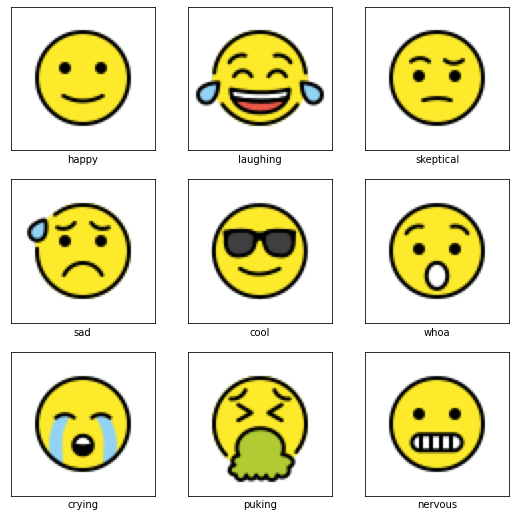

In [5]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join('emojis', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

## Creating Examples

In [6]:
for class_id, values in emojis.items():
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    emojis[class_id]['image'] = new_file

In [7]:
emojis

{0: {'file': '1F642.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F4DBCEC3410>,
  'name': 'happy'},
 1: {'file': '1F602.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F4DBB7DF650>,
  'name': 'laughing'},
 2: {'file': '1F928.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F4DBB7D5A10>,
  'name': 'skeptical'},
 3: {'file': '1F630.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F4DBB7DFC10>,
  'name': 'sad'},
 4: {'file': '1F60E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F4DBB7DFA50>,
  'name': 'cool'},
 5: {'file': '1F62F.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F4DBB7E48D0>,
  'name': 'whoa'},
 6: {'file': '1F62D.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F4DBB7E4890>,
  'name': 'crying'},
 7: {'file': '1F92E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7F4DBB7E4290>,
  'name': 'puking'},
 8: {'file': '1F62C.png',
  'image'

In [8]:
def create_example():
  class_id = np.random.randint(0,9)
  image = np.ones((144,144,3)) * 255
  row = np.random.randint(0,72)
  col = np.random.randint(0,72)
  image[row: row+72, col:col+72, :] = np.array(emojis[class_id]['image'])
  return image.astype('uint8'), class_id, (row+10)/144, (col+10)/144

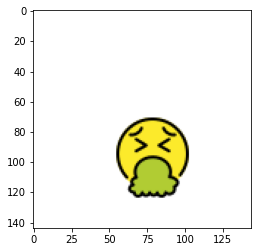

In [9]:
image, class_id, row, col = create_example()
plt.imshow(image)

## Design Plot Bounding Boxes Function

In [10]:
def plot_bounding_boxes(image, ori_coords, pred_coords=[], norm=False):
  if(norm):
    image*=255
    image = image.astype('uint8')
  image = Image.fromarray(image)
  draw = ImageDraw.Draw(image)

  row, col = ori_coords
  row*=144
  col*=144
  draw.rectangle((col, row, col+52, row+52), outline='green', width=2)

  if(len(pred_coords) == 2):
      row, col = pred_coords
      row*=144
      col*=144
      draw.rectangle((col, row, col+52, row+52), outline='red', width=2)
  
  return image

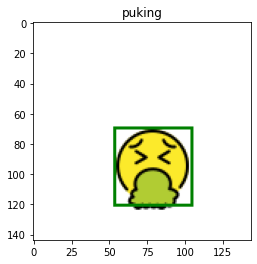

In [11]:
plt.imshow(plot_bounding_boxes(image,[row,col]))
plt.title(emojis[class_id]['name'])
plt.show()

## Design Data Generator Function

In [12]:
def data_generator(batch_size=16):
  while True:
    x_batch = np.zeros((batch_size,144,144,3))
    y_batch = np.zeros((batch_size,9))
    bbox_batch = np.zeros((batch_size,2))

    for i in range(0, batch_size):
      image, class_id, row, col = create_example()
      x_batch[i] = image/255.
      y_batch[i, class_id] = 1.0
      bbox_batch[i] = np.array([row,col])
    
    yield {'images' : x_batch}, {'class_ids': y_batch, 'bboxes' : bbox_batch}

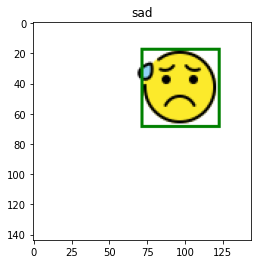

In [13]:
images, label = next(data_generator(10))
image = images['images'][2]
class_id = np.argmax(label['class_ids'][2])
coords = label['bboxes'][2]

plt.imshow(plot_bounding_boxes(image,coords, norm=True))
plt.title(emojis[class_id]['name'])
plt.show()

## Designing Model

In [14]:
input_layer = Input(shape=(144,144,3), name='images')

x= input_layer
for i in range(0,5):
  n_filters = 2**(4+i)
  x = Conv2D(n_filters,3,activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dense(256,activation='relu')(x)

class_ids = Dense(9,activation='softmax',name='class_ids')(x)
bboxes = Dense(2,name='bboxes')(x)

model = tf.keras.models.Model(input_layer,[class_ids,bboxes])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 144, 144, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 142, 142, 16) 448         images[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 142, 142, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 71, 71, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Designing Custom Metric: IoU

In [15]:
class IoU(tf.keras.metrics.Metric):
  def __init__(self, **kwargs):
    super(IoU, self).__init__(**kwargs)

    self.iou = self.add_weight(name='iou', initializer='zeros')
    self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
    self.num_ex = self.add_weight(name='num_ex', initializer='zeros')
  
  def update_state(self, y_true, y_pred, sample_weight=None):
    def get_box(y):
      rows, cols = y[:, 0]* 144, y[:, 1]* 144
      y1, y2 = rows, rows + 52
      x1, x2 = cols, cols + 52
      return x1, y1, x2, y2
    
    def get_area(x1, y1, x2, y2):
      return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)
    
    gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
    p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)

    i_x1 = tf.maximum(gt_x1, p_x1)
    i_y1 = tf.maximum(gt_y1, p_y1)
    i_x2 = tf.minimum(gt_x2, p_x2)
    i_y2 = tf.minimum(gt_y2, p_y2)

    i_area = get_area(i_x1, i_y1, i_x2, i_y2)
    u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area

    iou = tf.math.divide(i_area, u_area)
    self.num_ex.assign_add(1)
    self.total_iou.assign_add(tf.reduce_mean(iou))
    self.iou = tf.math.divide(self.total_iou, self.num_ex)
  
  def result(self):
    return self.iou
  
  def reset_state(self):
    self.iou = self.add_weight(name='iou', initializer='zeros')
    self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
    self.num_ex = self.add_weight(name='num_ex', initializer='zeros')


## Compile the Model

In [16]:
model.compile(loss={'class_ids' : 'categorical_crossentropy', 'bboxes' : 'mse'},
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics = {'class_ids' : 'accuracy', 'bboxes' : IoU(name='iou')}
              )

## Designing Custom Callback: Model Testing

In [17]:
def test_model(model,test_datagen):
  example, label = next(test_datagen)
  x = example['images']
  y = label['class_ids']
  box = label['bboxes']

  pred_y, pred_box = model.predict(x)

  pred_coords = pred_box[0]
  gt_coords = box[0]
  pred_class = np.argmax(pred_y[0])
  image = x[0]

  gt = emojis[np.argmax(y[0])]['name']
  pred_class_name = emojis[pred_class]['name']

  image = plot_bounding_boxes(image,gt_coords, pred_coords, norm = True)
  color = 'green' if gt==pred_class_name else 'red'

  plt.imshow(image)
  plt.xlabel(f'Pred: {pred_class_name}', color=color)
  plt.ylabel(f'Pred: {gt}', color=color)
  plt.xticks([])
  plt.yticks([])

In [18]:
def test(model):
  test_datagen = data_generator(1)

  plt.figure(figsize=(24,10))

  for i in range(6):
    plt.subplot(1,6,i+1)
    test_model(model,test_datagen)
  plt.show()

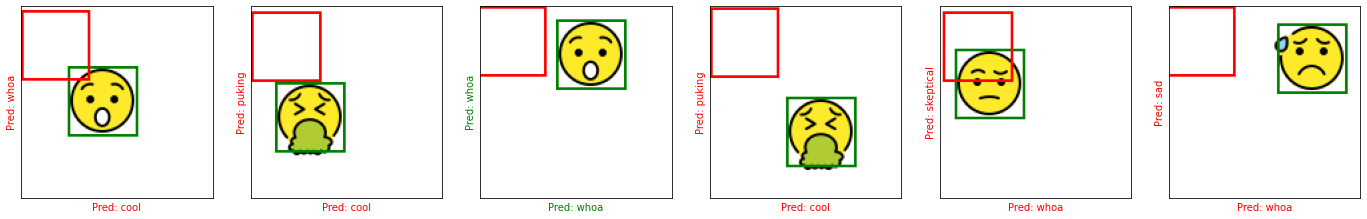

In [19]:
test(model)

In [20]:
class ShowTestImages(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs=None):
    test(self.model)

## Model Training

In [21]:
def lr_schedule(epoch,lr):
  if((epoch+1)%5 == 0):
    lr*=0.2
  return max(lr,3e-7)

Epoch 1/20
500/500 [==============================] - 10s 17ms/step - loss: 2.8635 - class_ids_loss: 1.5130 - bboxes_loss: 1.3505 - class_ids_accuracy: 0.4827 - bboxes_iou: 0.2093


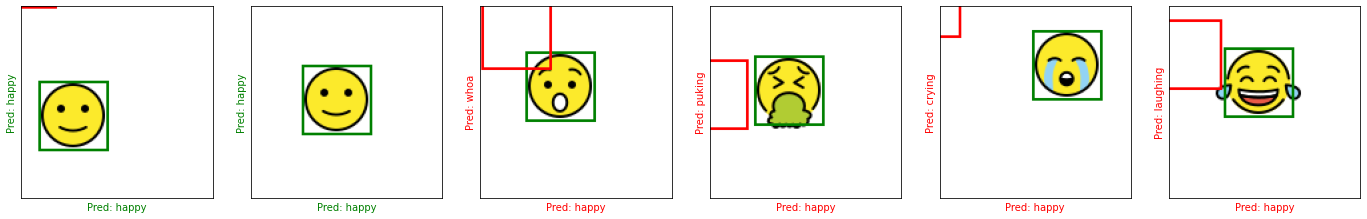

Epoch 2/20
500/500 [==============================] - 9s 17ms/step - loss: 0.0481 - class_ids_loss: 0.0145 - bboxes_loss: 0.0336 - class_ids_accuracy: 0.9989 - bboxes_iou: 0.2759


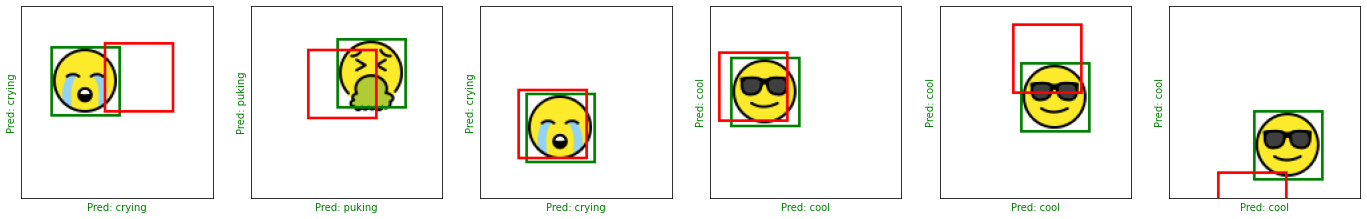

Epoch 3/20
500/500 [==============================] - 9s 17ms/step - loss: 0.0216 - class_ids_loss: 0.0036 - bboxes_loss: 0.0181 - class_ids_accuracy: 1.0000 - bboxes_iou: 0.3724


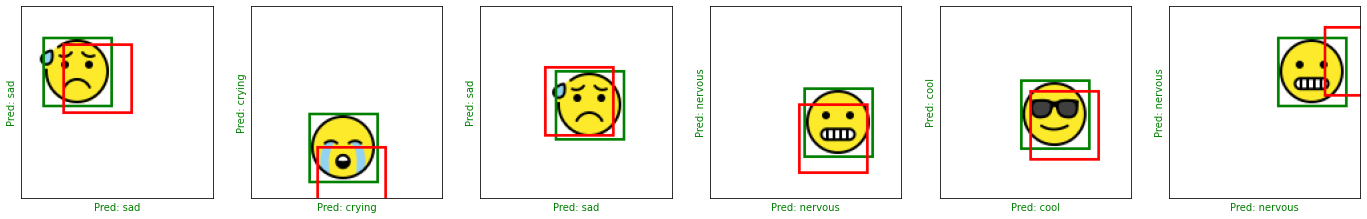

Epoch 4/20
500/500 [==============================] - 9s 18ms/step - loss: 0.0119 - class_ids_loss: 0.0025 - bboxes_loss: 0.0094 - class_ids_accuracy: 0.9997 - bboxes_iou: 0.4805


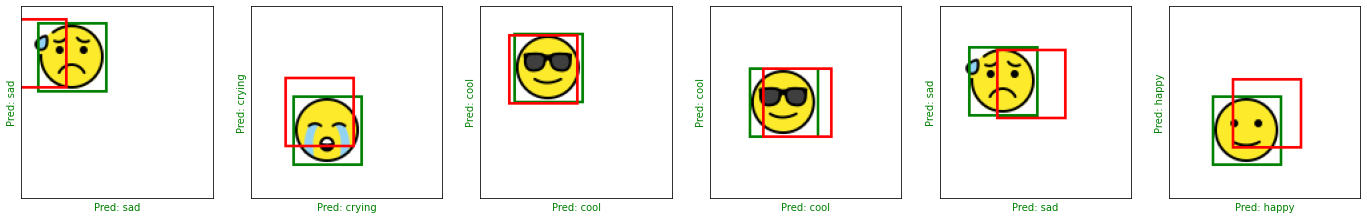

Epoch 5/20
500/500 [==============================] - 9s 18ms/step - loss: 0.0053 - class_ids_loss: 0.0011 - bboxes_loss: 0.0043 - class_ids_accuracy: 1.0000 - bboxes_iou: 0.6007


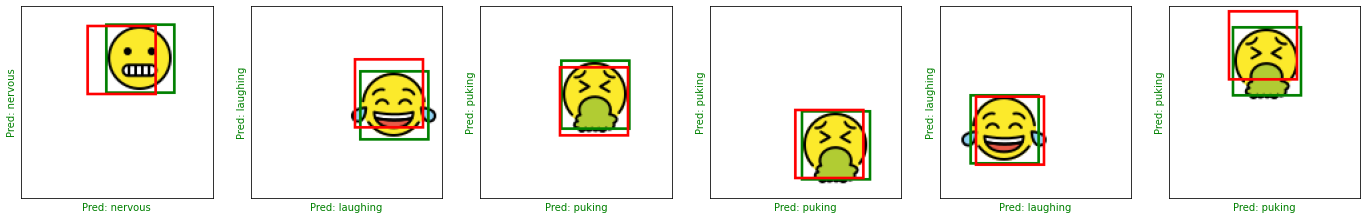

Epoch 6/20
500/500 [==============================] - 9s 18ms/step - loss: 0.0040 - class_ids_loss: 8.8571e-04 - bboxes_loss: 0.0032 - class_ids_accuracy: 1.0000 - bboxes_iou: 0.6409


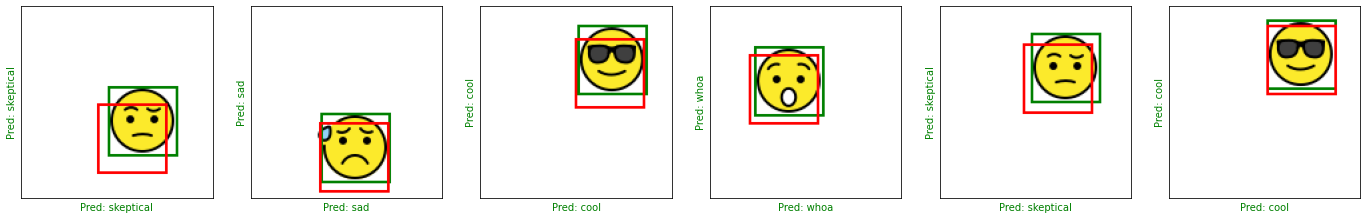

Epoch 7/20
500/500 [==============================] - 9s 18ms/step - loss: 0.0038 - class_ids_loss: 7.3991e-04 - bboxes_loss: 0.0030 - class_ids_accuracy: 1.0000 - bboxes_iou: 0.6463


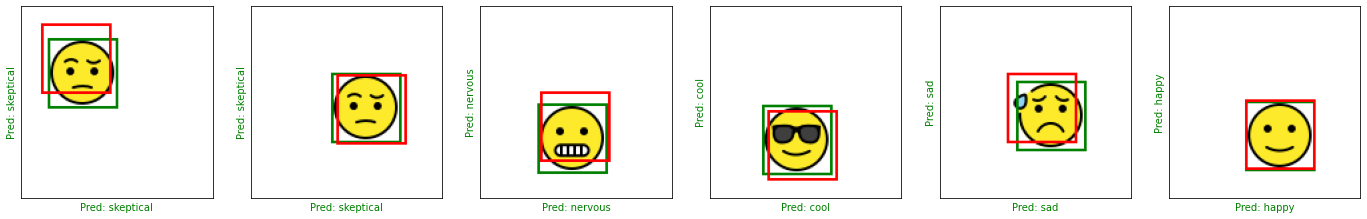

Epoch 8/20
500/500 [==============================] - 9s 18ms/step - loss: 0.0033 - class_ids_loss: 5.5791e-04 - bboxes_loss: 0.0027 - class_ids_accuracy: 1.0000 - bboxes_iou: 0.6606


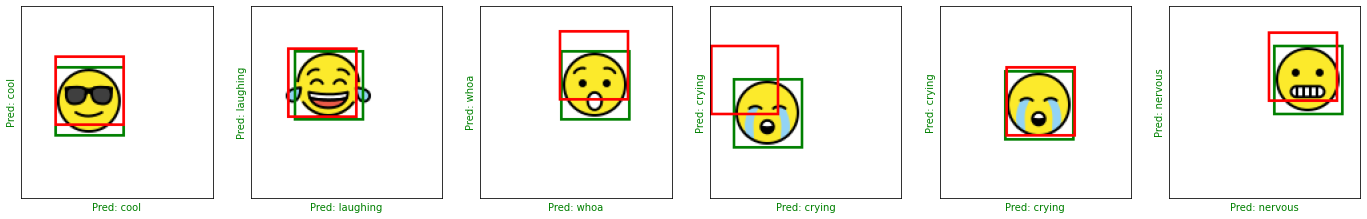

Epoch 9/20
500/500 [==============================] - 9s 19ms/step - loss: 0.0033 - class_ids_loss: 5.9596e-04 - bboxes_loss: 0.0027 - class_ids_accuracy: 1.0000 - bboxes_iou: 0.6618


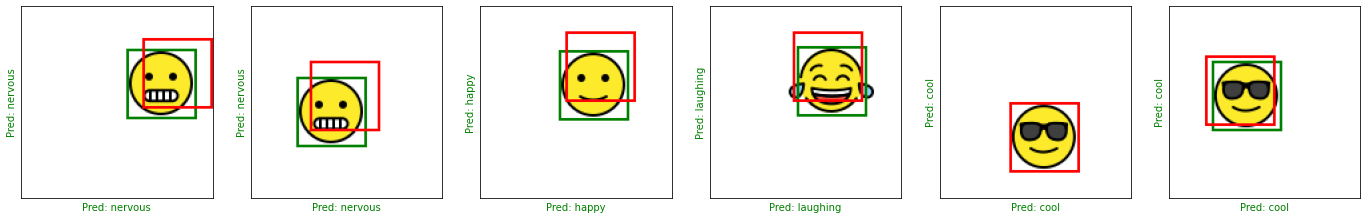

Epoch 10/20
500/500 [==============================] - 9s 19ms/step - loss: 0.0025 - class_ids_loss: 5.1878e-04 - bboxes_loss: 0.0020 - class_ids_accuracy: 1.0000 - bboxes_iou: 0.6999


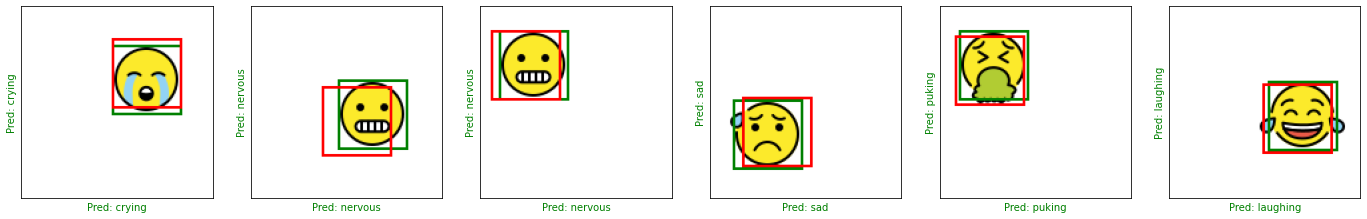

Epoch 11/20
500/500 [==============================] - 10s 19ms/step - loss: 0.0021 - class_ids_loss: 4.0442e-04 - bboxes_loss: 0.0017 - class_ids_accuracy: 1.0000 - bboxes_iou: 0.7182


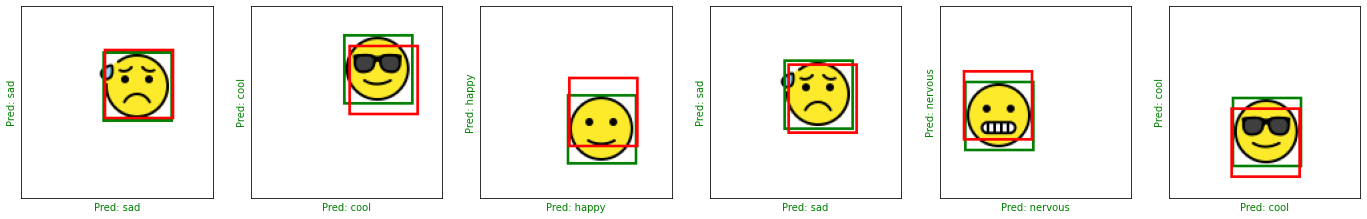

Epoch 12/20
500/500 [==============================] - 10s 19ms/step - loss: 0.0020 - class_ids_loss: 3.4754e-04 - bboxes_loss: 0.0017 - class_ids_accuracy: 1.0000 - bboxes_iou: 0.7197


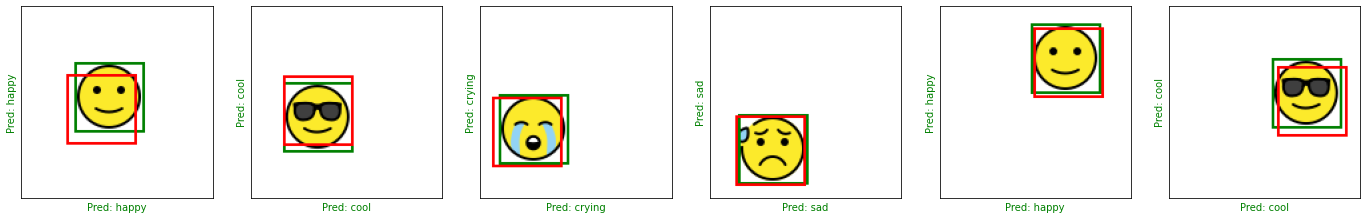

Epoch 13/20
500/500 [==============================] - 10s 19ms/step - loss: 0.0019 - class_ids_loss: 3.3348e-04 - bboxes_loss: 0.0016 - class_ids_accuracy: 1.0000 - bboxes_iou: 0.7235


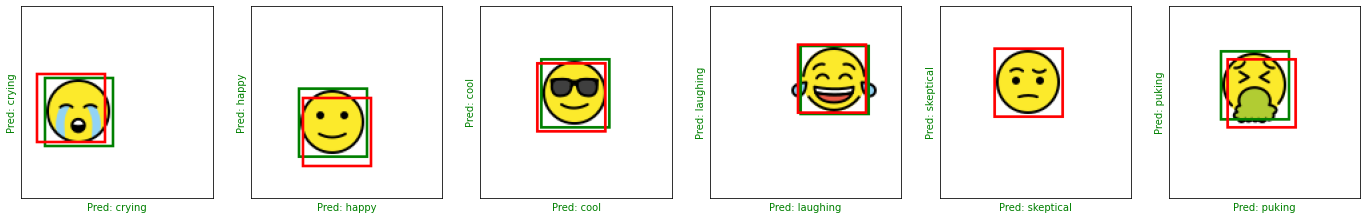

Epoch 14/20
500/500 [==============================] - 10s 20ms/step - loss: 0.0018 - class_ids_loss: 2.6112e-04 - bboxes_loss: 0.0015 - class_ids_accuracy: 1.0000 - bboxes_iou: 0.7307


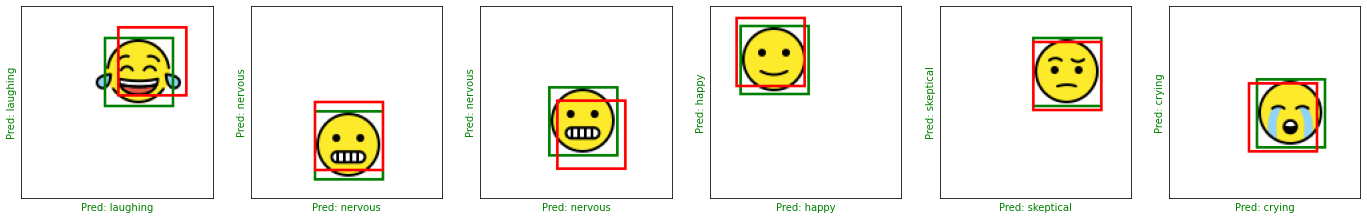

Epoch 15/20
500/500 [==============================] - 10s 20ms/step - loss: 0.0017 - class_ids_loss: 3.0106e-04 - bboxes_loss: 0.0014 - class_ids_accuracy: 1.0000 - bboxes_iou: 0.7386


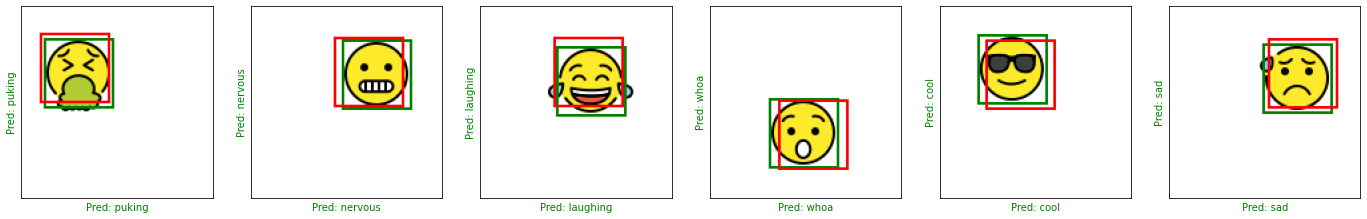

Epoch 16/20
500/500 [==============================] - 10s 20ms/step - loss: 0.0016 - class_ids_loss: 3.2425e-04 - bboxes_loss: 0.0013 - class_ids_accuracy: 1.0000 - bboxes_iou: 0.7451


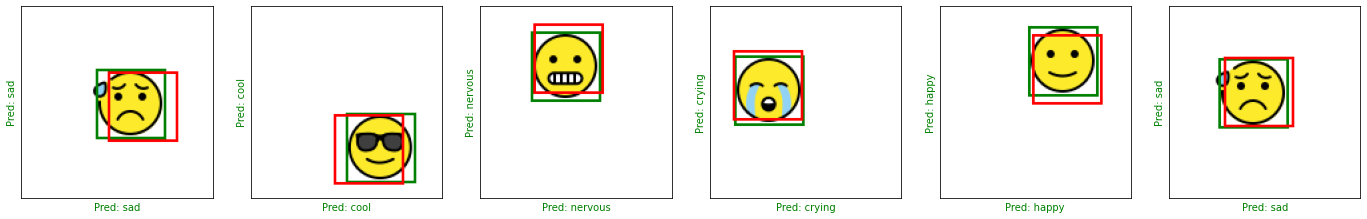

Epoch 17/20
500/500 [==============================] - 10s 20ms/step - loss: 0.0018 - class_ids_loss: 4.6746e-04 - bboxes_loss: 0.0014 - class_ids_accuracy: 1.0000 - bboxes_iou: 0.7409


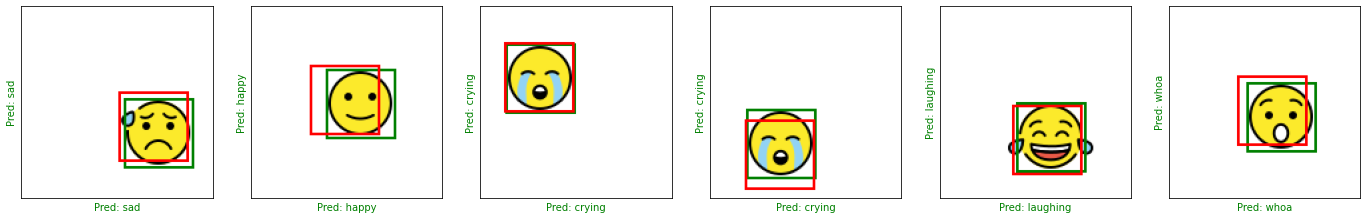

Epoch 18/20
500/500 [==============================] - 10s 20ms/step - loss: 0.0015 - class_ids_loss: 2.5265e-04 - bboxes_loss: 0.0012 - class_ids_accuracy: 1.0000 - bboxes_iou: 0.7507


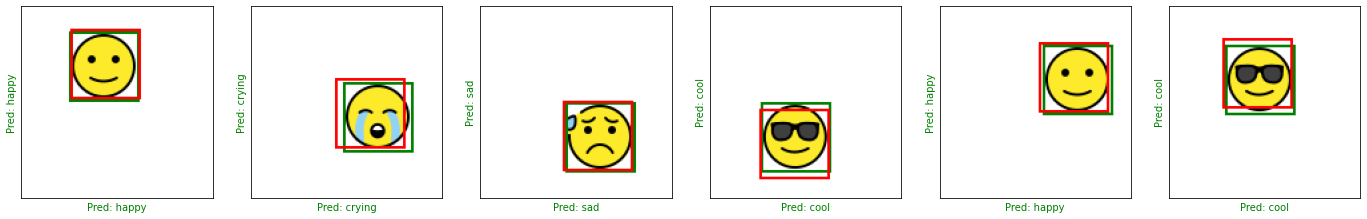

Epoch 19/20
500/500 [==============================] - 10s 20ms/step - loss: 0.0015 - class_ids_loss: 2.3879e-04 - bboxes_loss: 0.0013 - class_ids_accuracy: 1.0000 - bboxes_iou: 0.7452


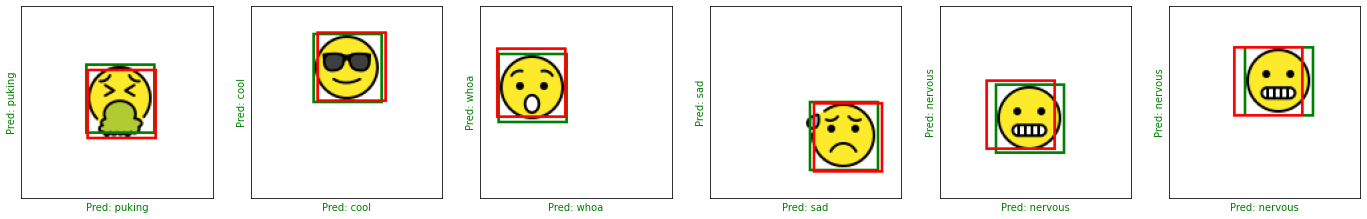

Epoch 20/20
500/500 [==============================] - 10s 20ms/step - loss: 0.0015 - class_ids_loss: 2.5812e-04 - bboxes_loss: 0.0012 - class_ids_accuracy: 1.0000 - bboxes_iou: 0.7547


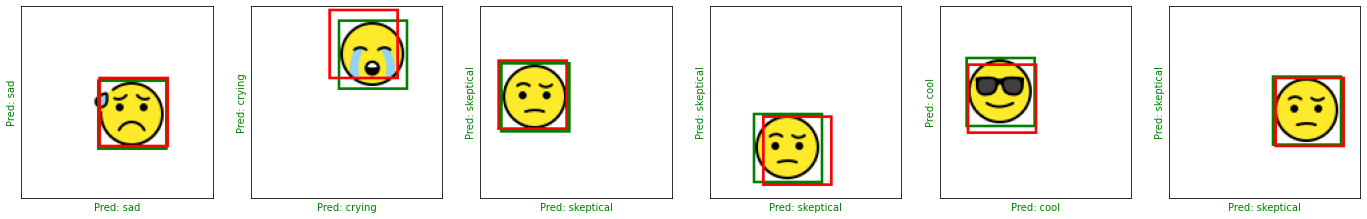

In [22]:
history = model.fit(
    data_generator(),
    epochs = 20,
    steps_per_epoch = 500,
    callbacks = [
                 ShowTestImages(),
                 tf.keras.callbacks.EarlyStopping(monitor='bboxes_iou', patience=3, mode='max'),
                 tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ])